## Carregando Bibliotecas

In [1]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import spacy
from wordcloud import WordCloud

## Carregando DataFrame

Para os códigos e análises de processamento de linguagem natural (NLP), será só considerado as colunas `avaliacao` (Label) e `texto_processado` (documentos).


In [2]:
data_path = r"..\data\reviews_processed_llm.json"

df = pd.read_json(data_path, encoding='utf-8')

df = df[["avaliacao", "texto_processado"]]

df.head()

,avaliacao,texto_processado
0,Recommended,A investigação é incrível e a história é absur...
1,Recommended,Eu aguardei por muito tempo para jogar esse jo...
2,Recommended,"Gosto da ambientação, enigmas e personagens, a..."
3,Recommended,"Compatibilidade péssima, mas... ordem paranorm..."
4,Recommended,"A estética do jogo é simplesmente incrível, co..."


## Informações básicas

Se pode observar nos notebooks a seguir, que as colunas são carregadas como objetos pois estão em um formato textual e não possuem Nulos. Já o Label `avaliacao` possui um grande volume de classes positivas, sendo 96.42% de avaliações recomendadas.

In [92]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6535 entries, 0 to 6534
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   avaliacao         6535 non-null   object
 1   texto_processado  6535 non-null   object
dtypes: object(2)
memory usage: 102.2+ KB


In [93]:
df['avaliacao'].value_counts()

avaliacao
Recommended        6301
Not Recommended     234
Name: count, dtype: int64

In [94]:
round((df['avaliacao'].value_counts() / df.shape[0]) * 100, 2).astype(str) + "%"

avaliacao
Recommended        96.42%
Not Recommended     3.58%
Name: count, dtype: object

# Removendo Stop Words

Para a criação dos gráficos de nuvem de palavras, foi feita a função `remove_stop_words` que retorna o documento sem stop words. 

In [3]:
nlp = spacy.load("pt_core_news_lg")

def remove_stop_words(text):
    text_lower = text.lower().strip()
    doc = nlp(text_lower)
    words_no_stop = [token.text for token in doc if not token.is_stop]
    return " ".join(words_no_stop)



df["texto_processado_no_stop"] = df["texto_processado"].apply(remove_stop_words)

## Nuvem de palavras

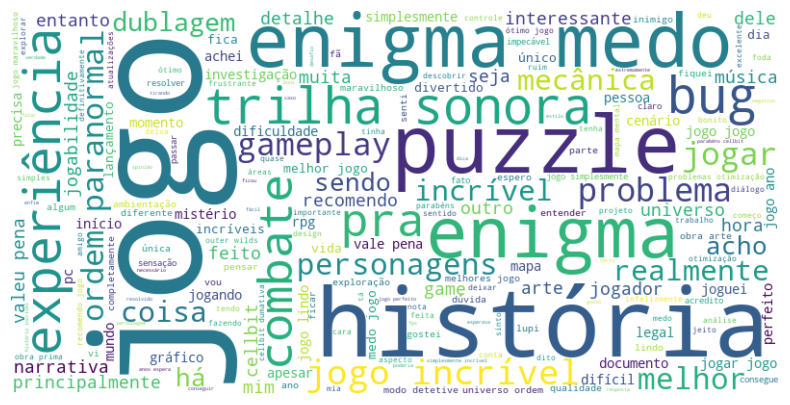

In [74]:
def make_WordCloud(text, word_cloud:WordCloud):
    nuvem = word_cloud.generate(text)

    # Exibir a nuvem de palavras
    plt.figure(figsize=(10, 5))
    plt.imshow(nuvem, interpolation='bilinear')
    plt.axis('off')  # Não mostrar os eixos
    plt.show()

cloud = WordCloud(width=800, height=400, background_color='white',colormap="viridis")


# Nuvem de palavras All dataset
make_WordCloud(" ".join(df["texto_processado_no_stop"]), cloud)


Na nuvem de palavras que considera todo o dataset, é 

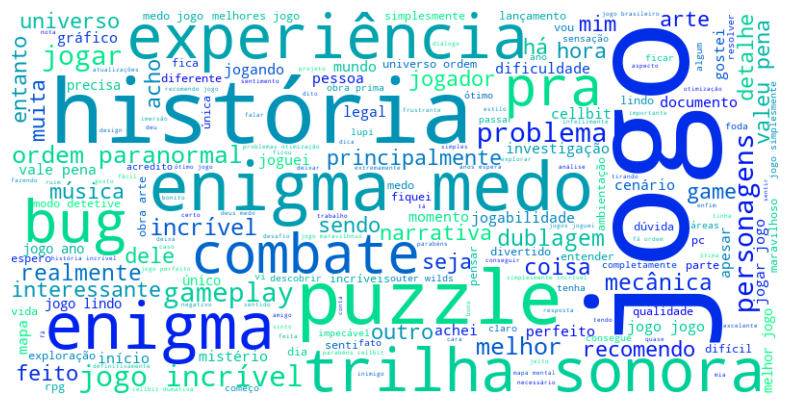

In [76]:
cloud_positive = WordCloud(width=800, height=400, background_color='white', colormap="winter")

make_WordCloud(" ".join(df["texto_processado_no_stop"].loc[df["avaliacao"] == "Recommended"]), cloud_positive)

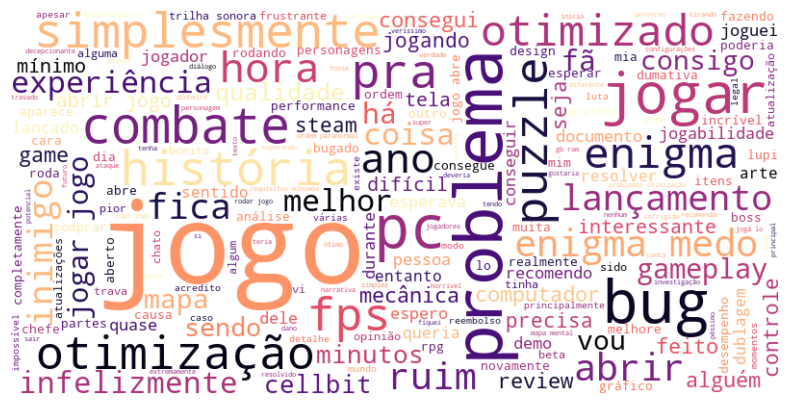

In [77]:
cloud_negative = WordCloud(width=800, height=400, background_color='white', colormap="magma")

make_WordCloud(" ".join(df["texto_processado_no_stop"].loc[df["avaliacao"] == "Not Recommended"]), cloud_negative)

### Depois

In [78]:
import pandas as pd
import numpy as np

# Função para criar o sample igualitário
def create_equal_sample(df, class_col):
    classes = df[class_col].unique()
    class_counts = df[class_col].value_counts()
    min_count = class_counts.min()
    
    samples = []
    for class_name in classes:
        class_df = df[df[class_col] == class_name].sample(min_count, random_state=42)
        samples.append(class_df)
    
    df_sample = pd.concat(samples).reset_index(drop=True)
    return df_sample




In [79]:
# Parâmetros
class_col = 'avaliacao'


# Criar o sample
df_sample = create_equal_sample(df, class_col)


df_sample["avaliacao"].value_counts()

avaliacao
Recommended        234
Not Recommended    234
Name: count, dtype: int64

## df-idf

In [80]:
from sklearn.model_selection import train_test_split

X = df_sample['texto_processado_no_stop']  # this time we want to look at the text
y = df_sample['avaliacao']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [81]:
from sklearn.feature_extraction.text import CountVectorizer
count_vect = CountVectorizer()

X_train_counts = count_vect.fit_transform(X_train)
X_train_counts.shape

(374, 3706)

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC

#Term frequency
# Inverse Document Frequency
# TFIDF(t,d) = TF(t, d) x IDF(t)
text_clf = Pipeline([('tfidf', TfidfVectorizer()),
                     ('clf', LinearSVC()),
])

text_clf.fit(X_train, y_train)  

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', LinearSVC())])

In [83]:
predictions = text_clf.predict(X_test)

<Axes: >

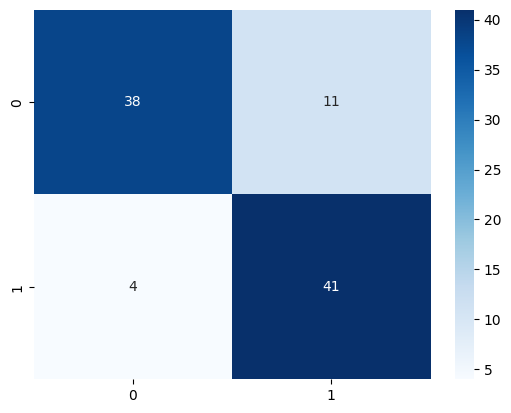

In [84]:
import seaborn as sns
from sklearn import metrics

cf_matrix = metrics.confusion_matrix(y_test,predictions)
sns.heatmap(cf_matrix, annot=True, fmt='d', cmap='Blues')

In [85]:
# Métricas do treinamento
print(metrics.classification_report(y_test,predictions))

                 precision    recall  f1-score   support

Not Recommended       0.90      0.78      0.84        49
    Recommended       0.79      0.91      0.85        45

       accuracy                           0.84        94
      macro avg       0.85      0.84      0.84        94
   weighted avg       0.85      0.84      0.84        94



In [86]:
from sklearn.model_selection import KFold, cross_val_score
import numpy as np

cross_val = KFold(n_splits=5, shuffle=True, random_state=42)

scores = cross_val_score(text_clf, X, y, cv=cross_val)

# Exibir os resultados
print("Acurácia em cada fold:", scores)
print("Acurácia média:", np.mean(scores))

Acurácia em cada fold: [0.84042553 0.81914894 0.85106383 0.77419355 0.72043011]
Acurácia média: 0.8010523907572639


## Bert

In [87]:
# Parâmetros
class_col = 'avaliacao'


# Criar o sample
df_sample = create_equal_sample(df, class_col)


df_sample["avaliacao"].value_counts()

df_sample["label"] = 0
df_sample.loc[df_sample["avaliacao"].isin(["Recommended"]), "label"] = 1

df_sample.head()

,avaliacao,texto_review,texto_processado,texto_review_no_stop,texto_processadono_stop,texto_processadono_no_stop,texto_processado_no_stop,label
0,Recommended,do que joguei até agora achei bem legalvarios ...,Do que joguei até agora achei bem legal. Vário...,"joguei achei legalvarios positivos , negativos...","joguei achei legal . positivos , negativos : g...","joguei achei legal . positivos , negativos : g...","joguei achei legal . positivos , negativos : g...",1
1,Recommended,nao tenho palavras pra descrever essas 60 hora...,Não tenho palavras para descrever essas 60 hor...,nao palavras pra descrever 60 horas jogo ... m...,palavras descrever 60 horas jogo ... melhor ar...,palavras descrever 60 horas jogo ... melhor ar...,palavras descrever 60 horas jogo ... melhor ar...,1
2,Recommended,Jogo muito bombem acima das minhas expectativa...,"Jogo muito bom acima das minhas expectativas, ...","jogo bombem acima expectativas , negativos com...","jogo acima expectativas , negativos combate , ...","jogo acima expectativas , negativos combate , ...","jogo acima expectativas , negativos combate , ...",1
3,Recommended,UM DOS MELHORES DOS DA MINHA VIDA SE O MELHOR,"Um dos melhores do meu tempo, sem dúvida o mel...",melhores vida melhor,"melhores , dúvida melhor .","melhores , dúvida melhor .","melhores , dúvida melhor .",1
4,Recommended,Ai Caralho...,"Ah, meu Deus...",ai caralho ...,"ah , deus ...","ah , deus ...","ah , deus ...",1


In [88]:
from sklearn.model_selection import train_test_split

# Dataset inicial
X = df_sample['texto_processado']
y = df_sample['label']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
import spacy

nlp = spacy.load("pt_core_news_lg")

words_pt = set(nlp.vocab.strings)

In [ ]:
with open('vocab.txt', 'w', encoding='utf-8') as f:
  for token in words_pt:
    f.write(token + '\n')

In [ ]:
from sklearn.model_selection import train_test_split

X = df_sample['texto_processado']  # this time we want to look at the text
y = df_sample['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
from transformers import DistilBertConfig, DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch

# Dataset inicial
X = df_sample['texto_processado']
y = df_sample['label']

# Divisão em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Carregar o vocabulario customizado
vocab_file = '/content/vocab.txt'


# Configurar o modelo com vocabulário ajustado
config = DistilBertConfig(
    vocab_size=len(words_pt),  # Tamanho do vocabulário personalizado
    # num_labels=2,  # Número de classes na tarefa de classificação
    # hidden_size=768,  # Tamanho dos vetores no espaço latente
    # num_attention_heads=12,  # Cabeças de atenção
    # intermediate_size=3072,  # Tamanho da camada intermediária
    # num_hidden_layers=6  # Número de camadas
)

# Inicializar o tokenizador com o vocab_file
tokenizer = DistilBertTokenizer(vocab_file=vocab_file)

# Tokenizar os textos e criar tensores
def prepare_data(texts, labels):
    encodings = tokenizer(
        list(texts),
        padding="max_length",  # Pad to the maximum sequence length
        truncation=True,       # Truncate sequences exceeding max_length
        max_length=256,       # Set a maximum sequence length (adjust if needed)
        return_tensors="pt"
    )
    labels_tensor = torch.tensor(labels.values, dtype=torch.long)
    encodings["labels"] = labels_tensor
    return encodings

train_encodings = prepare_data(X_train, y_train)
test_encodings = prepare_data(X_test, y_test)

# Criar datasets PyTorch
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __len__(self):
        return len(self.encodings["input_ids"])

    def __getitem__(self, idx):
        return {key: tensor[idx] for key, tensor in self.encodings.items()}

train_dataset = CustomDataset(train_encodings)
test_dataset = CustomDataset(test_encodings)

# Carregar o modelo usando a configuração customizada
model = DistilBertForSequenceClassification(config)

# Definir métricas de avaliação
def compute_metrics(pred):
    logits, labels = pred
    predictions = logits.argmax(axis=-1)
    acc = accuracy_score(labels, predictions)
    f1 = f1_score(labels, predictions, average="weighted")
    return {"accuracy": acc, "f1": f1}

# Configurar o treinamento com Early Stopping
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=50,
    weight_decay=0.20,
    logging_dir="./logs",
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=2,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
)

# Early Stopping Callback com paciência
early_stopping_callback = EarlyStoppingCallback(
    early_stopping_patience=3,
    early_stopping_threshold=0.01
)

# Inicializar o Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
    callbacks=[early_stopping_callback],
)

# Treinar o modelo
trainer.train()

# Avaliar o modelo
trainer.evaluate()


/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,0.575600,0.678069,0.627660,0.627786
2,0.612500,0.656223,0.617021,0.594766
3,0.609000,0.583374,0.734043,0.730452
4,0.517600,0.630845,0.723404,0.718972
5,0.261000,0.577363,0.776596,0.775455
6,0.452300,0.909187,0.776596,0.773580
7,0.127200,0.515908,0.829787,0.829787
8,0.239700,0.674396,0.840426,0.840044
9,0.028800,0.731781,0.840426,0.840044
10,0.048700,0.892615,0.808511,0.808511


{'eval_loss': 0.7097588181495667,
 'eval_accuracy': 0.8829787234042553,
 'eval_f1': 0.8829123170504953,
 'eval_runtime': 0.255,
 'eval_samples_per_second': 368.64,
 'eval_steps_per_second': 47.06,
 'epoch': 15.0}

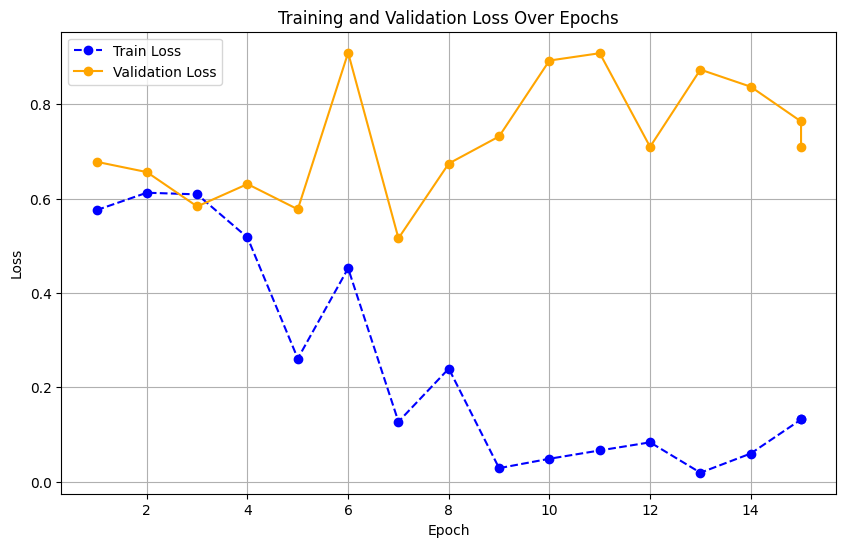

In [ ]:
history = trainer.state.log_history

# Converter o histórico para um DataFrame
df_history = pd.DataFrame(history)

df_history["loss_fill"] = df_history["loss"].ffill()

# Filtrar as linhas que possuem valor em 'eval_loss'
df_filtered = df_history.dropna(subset=["eval_loss"])

# Obter os valores de 'loss', 'eval_loss' e 'epoch' do dataset filtrado
epochs = df_filtered["epoch"]
train_loss = df_filtered["loss_fill"]
eval_loss = df_filtered["eval_loss"]

# Criar o gráfico
plt.figure(figsize=(10, 6))
plt.plot(epochs, train_loss, label="Train Loss", marker="o", linestyle="--", color="blue")
plt.plot(epochs, eval_loss, label="Validation Loss", marker="o", linestyle="-", color="orange")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
model.save_pretrained("./distilbert_model")
tokenizer.save_pretrained("./distilbert_model")


Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving vocabulary to ./distilbert_model/vocab.txt: vocabulary indices are not consecutive. Please check that the vocabulary is not corrupted!
Saving

('./distilbert_model/tokenizer_config.json',
 './distilbert_model/special_tokens_map.json',
 './distilbert_model/vocab.txt',
 './distilbert_model/added_tokens.json')

In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

tokenizer = DistilBertTokenizer.from_pretrained("./distilbert_model")
model = DistilBertForSequenceClassification.from_pretrained("./distilbert_model")


In [ ]:
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification
import torch

# Inicialize o tokenizer e o modelo
tokenizer = DistilBertTokenizer.from_pretrained("./distilbert_model")
model = DistilBertForSequenceClassification.from_pretrained("./distilbert_model")

# Exemplo de texto para classificação
text = "Jogo simplesmente incrível, a cada passo que você dá no jogo você consegue sentir todo o carinho colocado nele. Muitas vezes fiquei preso em alguns enigmas, mas a sensação de conseguir passar por eles é incrível. Dito isso, conseguiu apresentar o que prometeu: um jogo incrível repleto de enigmas e medo."
# Essa reviu foi Recommended

# Tokenize o texto
inputs = tokenizer(text, return_tensors="pt")

# Fazer previsão
with torch.no_grad():
    outputs = model(**inputs)

# Obter a previsão
logits = outputs.logits
predicted_class_id = torch.argmax(logits).item()

# Mapear a classe para um rótulo
label_map = {0: "Not Recommended", 1: "Recommended"}  # Ajuste conforme necessário
predicted_label = label_map[predicted_class_id]

print(f"Texto: {text}")
print(f"Classe prevista: {predicted_label}")


Texto: Jogo simplesmente incrível, a cada passo que você dá no jogo você consegue sentir todo o carinho colocado nele. Muitas vezes fiquei preso em alguns enigmas, mas a sensação de conseguir passar por eles é incrível. Dito isso, conseguiu apresentar o que prometeu: um jogo incrível repleto de enigmas e medo.
Classe prevista: Recommended


In [ ]:
list_not_recommended = [
    "Mesmo após a Demo e seus problemas de otimização, o jogo continua mal otimizado, não abre no nível do jogo. E isso é extremamente decepcionante, principalmente depois de todo o hype e de já terem dado o feedback na demo.",
    "Produto devolvido\nEu baixei e tentei jogar, mas, por falta de espaço para instalar o jogo, optei por solicitar o meu reembolso. Quem sabe se eu tenho sorte na próxima vez?",
    "Vou ser curto e direto: Esse jogo é ótimo, mas sendo uma série Insuportável. O gameplay está travado, difícil e cheio de bugs. Uma história boa até onde eu joguei.\nO preço é irreal, nunca poderia valer 65$. Minha recomendação é não comprá-lo por esse preço e com desdém pela otimização, a partir de 30 é viável"
]

list_recommended = [
    "Eu tenho medo!",
    "Não achei que realmente fosse ter medo, mas é aterrorizante. Achei o jogo uma obra de arte em todos os quesitos, pena que não tem uma opção de acessibilidade para desativar os flashes de luz, ou então a opção de diminuir a iluminação durante eles. Sou fotossensível, isso afetou um pouco minha experiência, mas eu amei.",
    "Ao jogar o jogo, senti uma mistura de emoções ao mesmo tempo. Por um lado, achei as referências aos jogos Resident Evil 7 e Outer Wilds muito inspiradoras e fui influenciado pelas experiências obtidas em ambos os jogos. No entanto, após explorar o jogo mais a fundo, comecei a sentir uma falta de novidade nas mecânicas dos desafios que enfrentei. Além disso, infelizmente, o jogo foi lançado com um grande problema: era muito lotado de bugs. Isso diminuiu drasticamente minha experiência, pois muitas vezes tive que lidar com problemas como o jogo crashar ou ter que voltar ao menu."
]

In [ ]:
def classify_text(text):
    inputs = tokenizer(text, return_tensors="pt")
    # Fazer previsão
    with torch.no_grad():
        outputs = model(**inputs)

    # Obter a previsão
    logits = outputs.logits
    predicted_class_id = torch.argmax(logits).item()

    # Mapear a classe para um rótulo
    label_map = {0: "Not Recommended", 1: "Recommended"}  # Ajuste conforme necessário
    predicted_label = label_map[predicted_class_id]
    return predicted_label




Não Recomendado

In [ ]:
print(f"Texto: {list_not_recommended[0]}")
print(f"Classe prevista: {classify_text(list_not_recommended[0])}")

Texto: Mesmo após a Demo e seus problemas de otimização, o jogo continua mal otimizado, não abre no nível do jogo. E isso é extremamente decepcionante, principalmente depois de todo o hype e de já terem dado o feedback na demo.
Classe prevista: Recommended


In [ ]:
print(f"Texto: {list_not_recommended[1]}")
print(f"Classe prevista: {classify_text(list_not_recommended[1])}")

Texto: Produto devolvido
Eu baixei e tentei jogar, mas, por falta de espaço para instalar o jogo, optei por solicitar o meu reembolso. Quem sabe se eu tenho sorte na próxima vez?
Classe prevista: Not Recommended


In [ ]:
print(f"Texto: {list_not_recommended[2]}")
print(f"Classe prevista: {classify_text(list_not_recommended[2])}")

Texto: Vou ser curto e direto: Esse jogo é ótimo, mas sendo uma série Insuportável. O gameplay está travado, difícil e cheio de bugs. Uma história boa até onde eu joguei.
O preço é irreal, nunca poderia valer 65$. Minha recomendação é não comprá-lo por esse preço e com desdém pela otimização, a partir de 30 é viável
Classe prevista: Not Recommended


Recomendado

In [ ]:
print(f"Texto: {list_recommended[0]}")
print(f"Classe prevista: {classify_text(list_recommended[0])}")

Texto: Eu tenho medo!
Classe prevista: Not Recommended


In [ ]:
print(f"Texto: {list_recommended[1]}")
print(f"Classe prevista: {classify_text(list_recommended[1])}")

Texto: Não achei que realmente fosse ter medo, mas é aterrorizante. Achei o jogo uma obra de arte em todos os quesitos, pena que não tem uma opção de acessibilidade para desativar os flashes de luz, ou então a opção de diminuir a iluminação durante eles. Sou fotossensível, isso afetou um pouco minha experiência, mas eu amei.
Classe prevista: Recommended


In [ ]:
print(f"Texto: {list_recommended[2]}")
print(f"Classe prevista: {classify_text(list_recommended[2])}")

Texto: Ao jogar o jogo, senti uma mistura de emoções ao mesmo tempo. Por um lado, achei as referências aos jogos Resident Evil 7 e Outer Wilds muito inspiradoras e fui influenciado pelas experiências obtidas em ambos os jogos. No entanto, após explorar o jogo mais a fundo, comecei a sentir uma falta de novidade nas mecânicas dos desafios que enfrentei. Além disso, infelizmente, o jogo foi lançado com um grande problema: era muito lotado de bugs. Isso diminuiu drasticamente minha experiência, pois muitas vezes tive que lidar com problemas como o jogo crashar ou ter que voltar ao menu.
Classe prevista: Recommended
